In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import get_data
import get_bestfit
import seawater as sw
from scipy import stats
from scipy import odr

In [2]:
def find_outliers(beta,x,y,dx,dy,inds=None):
    if len(beta)==1:
        beta = [1,beta[0]]
    xhat = (dy**2*x + dx**2*beta[0]*(y-beta[1]))/(dy**2+(dx*beta[0])**2)
    error = np.sqrt((xhat**2-2*xhat*x + x**2)/dx**2 + ((beta[0]*xhat)**2+2*beta[0]*xhat*(beta[1]-y)+(beta[1]-y)**2)/dy**2)
    error[x>xhat] *= -1
    if inds is None:
        outliers = np.abs(error/np.std(error))>3
    else:
        outliers = np.abs(error/np.std(error[inds]))>3
    return outliers

def offset_func(beta,x):
    return x+beta
offset_model = odr.Model(offset_func)

In [3]:
xlabel = 'BB9 (RR)'
ylabel = 'FLBB (RR)'

In [4]:
data_folder = '/Users/zerickso/Research/EXPORTS/Pacific/Data/SeaBASS'
folder = '%s/BB9_RR'%data_folder
data1_loc = get_data.get_BB9_RR(folder,get_data=False,verbose=True)
folder = '%s/CTD_Revelle'%data_folder
data2_loc = get_data.get_FLBB_RR(folder,get_data=False,verbose=False)

Output is time, lat, lon


In [5]:
inds1,inds2,dist,dtime = get_bestfit.find_nearby((data1_loc[0],data2_loc[0]),(data1_loc[1],data2_loc[1]),(data1_loc[2],data2_loc[2]),3/24,3,return_distances=True)
bad_inds = inds1==0 # this one doesn't have bbp_650 variable for some reason
inds1 = inds1[~bad_inds]; inds2 = inds2[~bad_inds]; dist = dist[~bad_inds]; dtime = dtime[~bad_inds]
folder = '%s/BB9_RR'%data_folder
data1 = get_data.get_BB9_RR(folder,wavelength=700,get_dives=inds1,verbose=True)
folder = '%s/CTD_Revelle'%data_folder
data2 = get_data.get_FLBB_RR(folder,get_dives=data2_loc[3][inds2],verbose=True)
print('%d matches found'%len(inds1))

Output is time, lat, lon, T, S, z, VSF, VSF_sd
Output is time, lat, lon, station, T, S, z, VSF
18 matches found


In [6]:
# reject any matches with Revelle during the early part of the deployment (things were optically weird then)
good_inds = data1[0]>241
data1 = [d[good_inds] for d in data1]
data2 = [d[good_inds] for d in data2]
print('Rejected %d matches because Revelle was not optically stable at the beginning'%np.sum(~good_inds))

Rejected 10 matches because Revelle was not optically stable at the beginning


In [7]:
filtered_data2 = [get_data.median_filter(VSF,depth=z) for VSF,z in zip(data2[7],data2[6])]
filtered_VSF2 = [d[0] for d in filtered_data2]
filtered_dep2 = [d[2] for d in filtered_data2]

In [8]:
inds = [np.abs(z-20)<10 for z in data1[5]]
data1_20 = [np.nanmean(V[i]) for V,i in zip(data1[6],inds)]
data1_20_sd = [np.nanstd(V[i]) for V,i in zip(data1[6],inds)]
data1_T_20 = [np.nanmean(T[i]) for T,i in zip(data1[3],inds)]
data1_S_20 = [np.nanmean(T[i]) for T,i in zip(data1[4],inds)]
inds = [np.abs(z-90)<10 for z in data1[5]]
data1_90 = [np.nanmean(V[i]) for V,i in zip(data1[6],inds)]
data1_90_sd = [np.nanstd(V[i]) for V,i in zip(data1[6],inds)]
data1_T_90 = [np.nanmean(T[i]) for T,i in zip(data1[3],inds)]
data1_S_90 = [np.nanmean(T[i]) for T,i in zip(data1[4],inds)]

inds = [np.abs(z-20)<10 for z in filtered_dep2]
data2_20 = [np.nanmean(V[i]) for V,i in zip(filtered_VSF2,inds)]
data2_20_sd = [np.nanstd(V[i]) for V,i in zip(filtered_VSF2,inds)]
inds = [np.abs(z-20)<10 for z in data2[6]]
data2_T_20 = [np.nanmean(T[i]) for T,i in zip(data2[4],inds)]
data2_S_20 = [np.nanmean(T[i]) for T,i in zip(data2[5],inds)]
inds = [np.abs(z-90)<10 for z in filtered_dep2]
data2_90 = [np.nanmean(V[i]) for V,i in zip(filtered_VSF2,inds)]
data2_90_sd = [np.nanstd(V[i]) for V,i in zip(filtered_VSF2,inds)]
inds = [np.abs(z-90)<10 for z in data2[6]]
data2_T_90 = [np.nanmean(T[i]) for T,i in zip(data2[4],inds)]
data2_S_90 = [np.nanmean(T[i]) for T,i in zip(data2[5],inds)]

In [9]:
VSF_1 = np.concatenate((data1_20,data1_90))
VSF_2 = np.concatenate((data2_20,data2_90))
VSF_1_sd = np.concatenate((data1_20_sd,data2_90_sd))
VSF_2_sd = np.concatenate((data2_20_sd,data2_90_sd))
T_1 = np.concatenate((data1_T_20,data1_T_90))
T_2 = np.concatenate((data2_T_20,data2_T_90))
S_1 = np.concatenate((data1_S_20,data1_S_90))
S_2 = np.concatenate((data2_S_20,data2_S_90))

In [10]:
dsalt = np.abs(S_1-S_2)
dtemp = np.abs(T_1-T_2)

In [11]:
x = VSF_1*2*np.pi*1.04
dx = np.sqrt((VSF_1_sd*2*np.pi*1.04)**2 + (x/1.04*0.005)**2)
y = VSF_2*2*np.pi*1.14
dy = np.sqrt((VSF_2_sd*2*np.pi*1.14)**2 + (y/1.14*0.01)**2)

inds = np.isfinite(x*y*dx*dy)

In [12]:
# first find outliers for both the line and offset
data = odr.RealData(x[inds], y[inds], sx=dx[inds], sy=dy[inds])
odr_line = odr.ODR(data, odr.unilinear, beta0=[1,0])
fit_line = odr_line.run()
odr_offset = odr.ODR(data, offset_model, beta0=[0])
fit_offset = odr_offset.run()
outliers = find_outliers(fit_line.beta,x,y,dx,dy,inds) & inds
iinds = inds & ~outliers
r = stats.pearsonr(x[iinds],y[iinds])[0]
print('n=%d (%d outliers removed), r^2=%.2f'%(np.sum(iinds),np.sum(outliers),r**2))

# then do it without the outliers
data = odr.RealData(x[iinds], y[iinds], sx=dx[iinds], sy=dy[iinds])
odr_line = odr.ODR(data, odr.unilinear, beta0=[1,0])
fit_line = odr_line.run()
odr_offset = odr.ODR(data, offset_model, beta0=[0])
fit_offset = odr_offset.run()

print('Best-fit  line:  b=%+.2f (%.2f) x1e-5, a=%.2f (%.2f)'
      %(fit_line.beta[1]*1e5,fit_line.sd_beta[1]*1e5,fit_line.beta[0],fit_line.sd_beta[0]))
print('Best-fit offset, b=%+.2f (%.2f) x1e-5'
      %(fit_offset.beta[0]*1e5,fit_offset.sd_beta[0]*1e5))

n=16 (0 outliers removed), r^2=0.94
Best-fit  line:  b=-2.83 (4.46) x1e-5, a=0.94 (0.05)
Best-fit offset, b=-7.30 (2.05) x1e-5


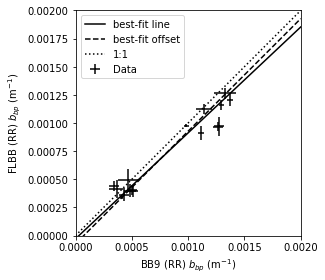

In [13]:
# plot results
xx = [0,2e-3]
plt.errorbar(x[iinds],y[iinds],xerr=dx[iinds],yerr=dy[iinds],ls='none',label='Data',clip_on=False,marker=',',color='k')
plt.plot(xx,np.polyval(fit_line.beta,xx),label='best-fit line',color='k')
plt.plot(xx,xx+fit_offset.beta,label='best-fit offset',color='k',ls='--')
plt.plot(xx,xx,label='1:1',color='k',ls=':')
plt.legend(loc=0)
plt.gca().set_aspect(1)

plt.xlim(xx)
plt.ylim(xx)
plt.xlabel(xlabel+' $b_{bp}$ (m$^{-1}$)')
plt.ylabel(ylabel+' $b_{bp}$ (m$^{-1}$)');

plt.tight_layout()

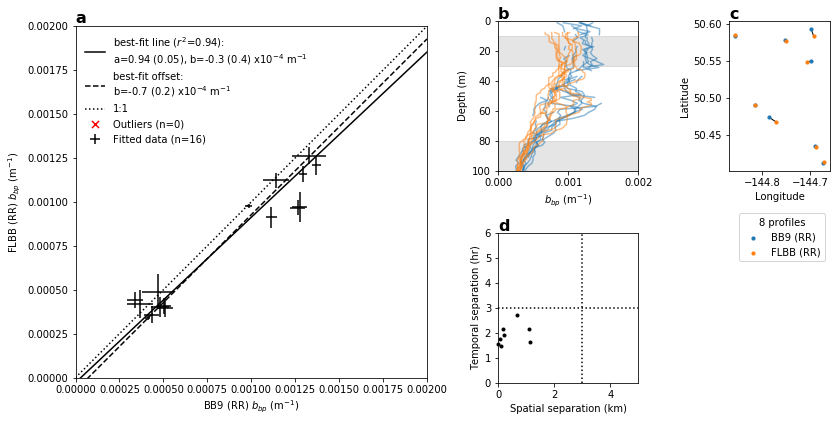

In [15]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
ax = [fig.add_subplot(gs[:, 0:2]),fig.add_subplot(gs[0,2]),fig.add_subplot(gs[0,3]),fig.add_subplot(gs[1,2]),fig.add_subplot(gs[1,3])]
xx = np.array([0,2e-3])
ax[0].errorbar(x[iinds],y[iinds],xerr=dx[iinds],yerr=dy[iinds],ls='none',
               label='Fitted data (n=%d)'%np.sum(iinds),clip_on=False,marker=',',color='k')
ax[0].plot(xx,np.polyval(fit_line.beta,xx),color='k',
           label='best-fit line ($r^2$=%.2f):\na=%.2f (%.2f), b=%+.1f (%.1f) x10$^{-4}$ m$^{-1}$'
           %(r**2,fit_line.beta[0],fit_line.sd_beta[0],fit_line.beta[1]*1e4,fit_line.sd_beta[1]*1e4))
ax[0].plot(xx,xx+fit_offset.beta,color='k',ls='--',label='best-fit offset:\nb=%+.1f (%.1f) x10$^{-4}$ m$^{-1}$'
           %(fit_offset.beta[0]*1e4,fit_offset.sd_beta[0]*1e4))
ax[0].plot(xx,xx,label='1:1',color='k',ls=':')
ax[0].scatter(x[outliers],y[outliers],c='r',zorder=-2,marker='x',s=50,label='Outliers (n=%d)'%np.sum(outliers))
for b,z in zip(data1[6],data1[5]):
    ax[1].plot(b*2*np.pi*1.02,z,c='C0',alpha=0.5)
for b,z in zip(filtered_VSF2,filtered_dep2):
    ax[1].plot(b*2*np.pi*1.02,z,c='C1',alpha=0.5)
ax[2].plot(np.vstack((data1[2],data2[2])),np.vstack((data1[1],data2[1])),c='k',lw=1,zorder=-1);
ax[2].scatter(data1[2],data1[1],label=xlabel,s=10)
ax[2].scatter(data2[2],data2[1],label=ylabel,s=10)
ax[3].scatter(dist[good_inds],dtime[good_inds]*24,clip_on=False,marker='.',c='k')

ax[0].set_xlim(xx)
ax[0].set_ylim(xx)
ax[0].set_xlabel(xlabel+' $b_{bp}$ (m$^{-1}$)')
ax[0].set_ylabel(ylabel+' $b_{bp}$ (m$^{-1}$)');
ax[0].legend(loc='upper left',frameon=False)
ax[0].set_aspect(1)
ax[1].set_xlim([0,2e-3])
ax[1].set_xticks(np.arange(0,0.0025,0.001))
ax[1].set_ylim([100,0])
ax[1].set_xlabel('$b_{bp}$ (m$^{-1}$)')
ax[1].set_ylabel('Depth (m)')
ax[1].fill_betweenx([10,30],xx[1],color='k',alpha=0.1)
ax[1].fill_betweenx([80,100],xx[1],color='k',alpha=0.1)
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Latitude')
xlim = ax[2].get_xlim()
ylim = ax[2].get_ylim()
ax[2].set_aspect(sw.dist(ylim,np.mean(xlim))[0]/sw.dist(np.mean(ylim),xlim)[0],anchor='N')
ax[3].set_xlim([0,5])
ax[3].set_ylim([0,6])
ax[3].set_xlabel('Spatial separation (km)')
ax[3].set_ylabel('Temporal separation (hr)');
ax[3].axhline(3,c='k',ls=':')
ax[3].axvline(3,c='k',ls=':')
ax[4].set_visible(False)

for a,p in zip(ax,['a','b','c','d','e']):
    a.text(0,1.01,p,fontsize=16,fontweight='bold',transform=a.transAxes)

plt.tight_layout()
ax[2].legend(loc=(0.1,-.6),title='%d profiles'%len(data1[0]))

plt.savefig('bbp_FLBBRR_BB9RR.png',dpi=300)